In [ ]:
%%capture
%pip install openmeteo-requests requests-cache retry-requests numpy pandas matplotlib torch scikit-learn scipy seaborn statsmodels seaborn timeseriesfcst tensorflow

# Setup


In [ ]:
import openmeteo_requests
import requests_cache
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from retry_requests import retry
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import timeseriesfcst as tsfcst
import timeseriesfcst.feature_engineering as hffe

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Define Constants


In [ ]:
# Constants
TRAIN_END = "2022-12-31"
VAL_START = "2023-01-01"
VAL_END = "2023-12-31"
TEST_START = "2024-01-01"

DATE_COL = "date"
SOLAR_PATH = "data/energy_charts.csv"


# Load Solar Data

In [ ]:
# Load solar data
solar_ts = pd.read_csv("data/energy_charts.csv", sep=",", header=0)
solar_ts["date"] = pd.to_datetime(solar_ts["Datum"], utc=True)
solar_ts.drop(columns=["Datum"], inplace=True)
solar_ts.set_index("date", inplace=True)

# Remove Duplicates

In [ ]:
# Keep the first occurrence of each duplicate
solar_ts = solar_ts[~solar_ts.index.duplicated(keep='first')]
pd.Series(solar_ts.index.duplicated()).value_counts()

# Check for duplicates again
if solar_ts.index.duplicated().any():
    print("Duplicates found:")
    print(solar_ts[solar_ts.index.duplicated(keep=False)])

# Interpolate Missing timestamps

In [ ]:
# Check for continuity
expected_range = pd.date_range(start=solar_ts.index.min(), end=solar_ts.index.max(), freq='15min')
missing_times = expected_range.difference(solar_ts.index)
if not missing_times.empty:
    print(f"Missing timestamps detected: {missing_times}")
    
# Create a full range of 15-min intervals
full_range = pd.date_range(start=solar_ts.index.min(), end=solar_ts.index.max(), freq='15min')
solar_ts = solar_ts.reindex(full_range)

# Interpolate missing values using time interpolation
solar_ts.interpolate(method='time', inplace=True)

In [ ]:
# Check for continuity
expected_range = pd.date_range(start=solar_ts.index.min(), end=solar_ts.index.max(), freq='15min')
missing_times = expected_range.difference(solar_ts.index)
if not missing_times.empty:
    print(f"Missing timestamps detected: {missing_times}")

# Resample from 15min to hourly sequences

In [ ]:
# Resample
solar_ts = solar_ts.resample('h').sum()

# Set the frequency to the inferred frequency of the DataFrame index
solar_ts = solar_ts.asfreq(pd.infer_freq(solar_ts.index))
solar_ts

# Load OMEO Weather Dataset for multivariate Model

In [ ]:
# Set up the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required train variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"

params = {
	"latitude": [53.1187, 50.0692, 51.9069, 48.7651, 50.9787, 54.0748],
	"longitude": [13.5022, 7.4415, 8.3785, 11.4237, 11.0328, 9.9819],
	"start_date": ["2014-01-01", "2014-01-01", "2014-01-01", "2014-01-01", "2014-01-01", "2014-01-01"   ],
	"end_date": ["2024-05-01", "2024-05-01", "2024-05-01", "2024-05-01", "2024-05-01", "2024-05-01"],
	"hourly": ["temperature_2m", "cloud_cover", "shortwave_radiation", "diffuse_radiation", "direct_normal_irradiance"],
	"timezone": ["Europe/Berlin", "Europe/Berlin", "Europe/Berlin", "Europe/Berlin", "Europe/Berlin", "Europe/Berlin"]
}

responses = openmeteo.weather_api(url, params=params)

# Process all locations
all_hourly_dataframes = []

for response in responses:
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")
    
    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_cloud_cover = hourly.Variables(1).ValuesAsNumpy()
    hourly_shortwave_radiation = hourly.Variables(2).ValuesAsNumpy()
    hourly_diffuse_radiation = hourly.Variables(3).ValuesAsNumpy()
    hourly_direct_normal_irradiance = hourly.Variables(4).ValuesAsNumpy()    
    
    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}
    hourly_data["temperature_2m"] = hourly_temperature_2m
    hourly_data["cloud_cover"] = hourly_cloud_cover
    hourly_data["shortwave_radiation"] = hourly_shortwave_radiation
    hourly_data["diffuse_radiation"] = hourly_diffuse_radiation
    hourly_data["direct_normal_irradiance"] = hourly_direct_normal_irradiance
    
    
    hourly_dataframe = pd.DataFrame(data = hourly_data)
    hourly_dataframe.set_index("date", inplace = True)
    
    # Add location information to the DataFrame
    # hourly_dataframe['latitude'] = response.Latitude()
    # hourly_dataframe['longitude'] = response.Longitude()
    
    all_hourly_dataframes.append(hourly_dataframe)

# Combine all DataFrames into a single DataFrame
combined_hourly_dataframe = pd.concat(all_hourly_dataframes, keys=range(len(all_hourly_dataframes)))

# Print the shape of the combined DataFrame to verify
print(f"Combined DataFrame shape: {combined_hourly_dataframe.shape}")
    

# Quick Cleandup and improved readability

In [ ]:
# Add "_city" to the column names in all_hourly_dataframes[0]
templin = all_hourly_dataframes[0].add_suffix("_templin")
kastellaun = all_hourly_dataframes[1].add_suffix("_kastellaun")
guetersloh = all_hourly_dataframes[2].add_suffix("_guetersloh")
ingolstadt = all_hourly_dataframes[3].add_suffix("_ingolstadt")
erfurt = all_hourly_dataframes[4].add_suffix("_erfurt")
neumunster = all_hourly_dataframes[5].add_suffix("_neumunster")

# Merge the DataFrames
hourly_dataframe = pd.concat([templin, kastellaun, guetersloh, ingolstadt, erfurt, neumunster], axis=1)
hourly_dataframe

# Merge Solar and Weather Data

In [ ]:
# merge with solar_ts
energy_ts = solar_ts.merge(hourly_dataframe, left_index=True, right_index=True, how='inner')
energy_ts.info()
energy_ts

# Partition


In [ ]:
# Split
train_ts = energy_ts[:TRAIN_END]  # Training data up to the end of 2022
val_ts = energy_ts[VAL_START:VAL_END]  # Validation data for the year 2023
test_ts = energy_ts[TEST_START:]  # Test data from the beginning of 2024 onwards

# Save to CSV


In [ ]:
# Save to CSV with datetime index
# train_ts.to_csv("data/train_ts.csv", header=True, index=True, index_label=False)
# val_ts.to_csv("data/val_ts.csv", header=True, index=True, index_label=False)
# test_ts.to_csv("data/test_ts.csv", header=True, index=True, index_label=False)

# Normalise

In [ ]:
# noramlise train val and test data based on train data
train_mean = train_ts.mean()
train_std = train_ts.std()

train_ts = (train_ts - train_mean) / train_std
val_ts = (val_ts - train_mean) / train_std
test_ts = (test_ts - train_mean) / train_std

# Handle Leap Years


# 

In [ ]:
# Check for duplicated dates
for ts in [train_ts, val_ts, test_ts]:
    if ts.index.duplicated().any():
        print("Duplicates found:")
        print(ts[ts.index.duplicated(keep=False)])

# Keep the first occurrence of each duplicate
for i, ts in enumerate([train_ts, val_ts, test_ts]):
    ts = ts[~ts.index.duplicated(keep='first')]
    if i == 0:
        train_ts = ts
    elif i == 1:
        val_ts = ts
    else:
        test_ts = ts

# Confirm that there are no duplicates anymore
for ts in [train_ts, val_ts, test_ts]:
    print(pd.Series(ts.index.duplicated()).value_counts())

# **Decompose Time Series**

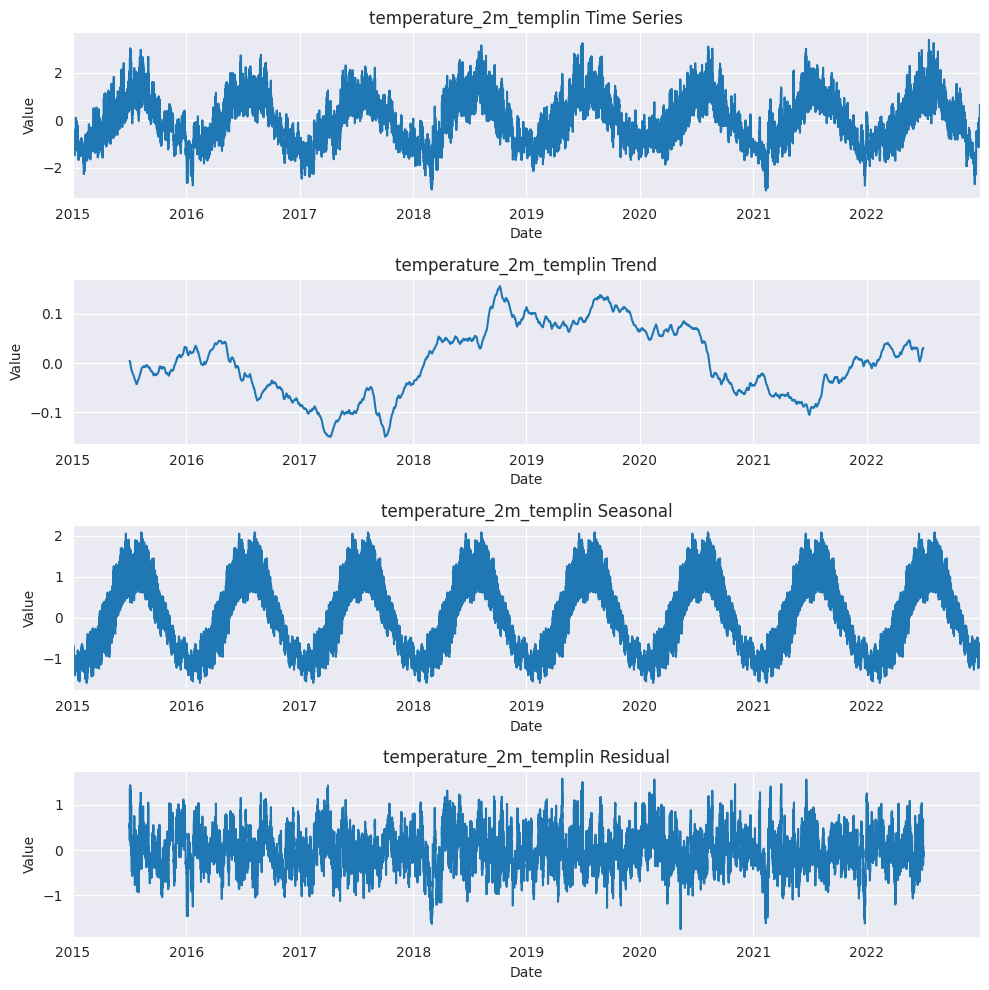

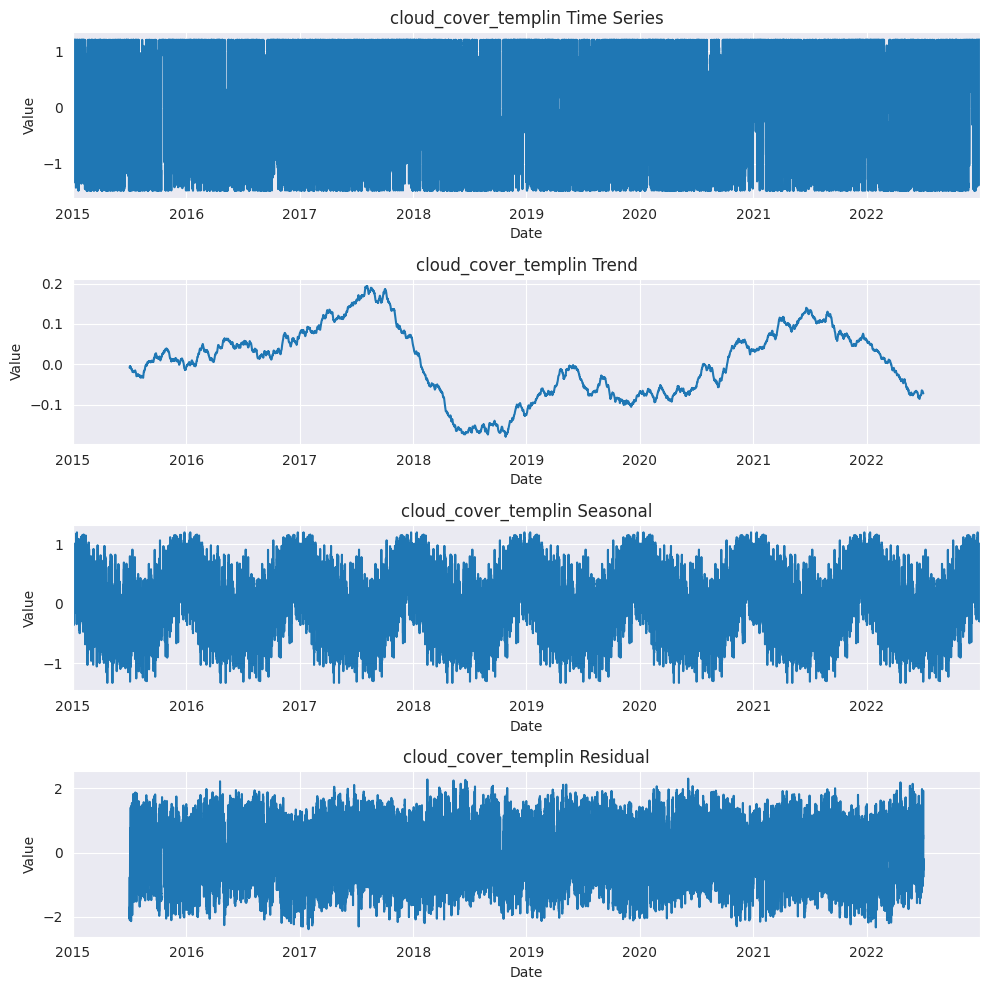

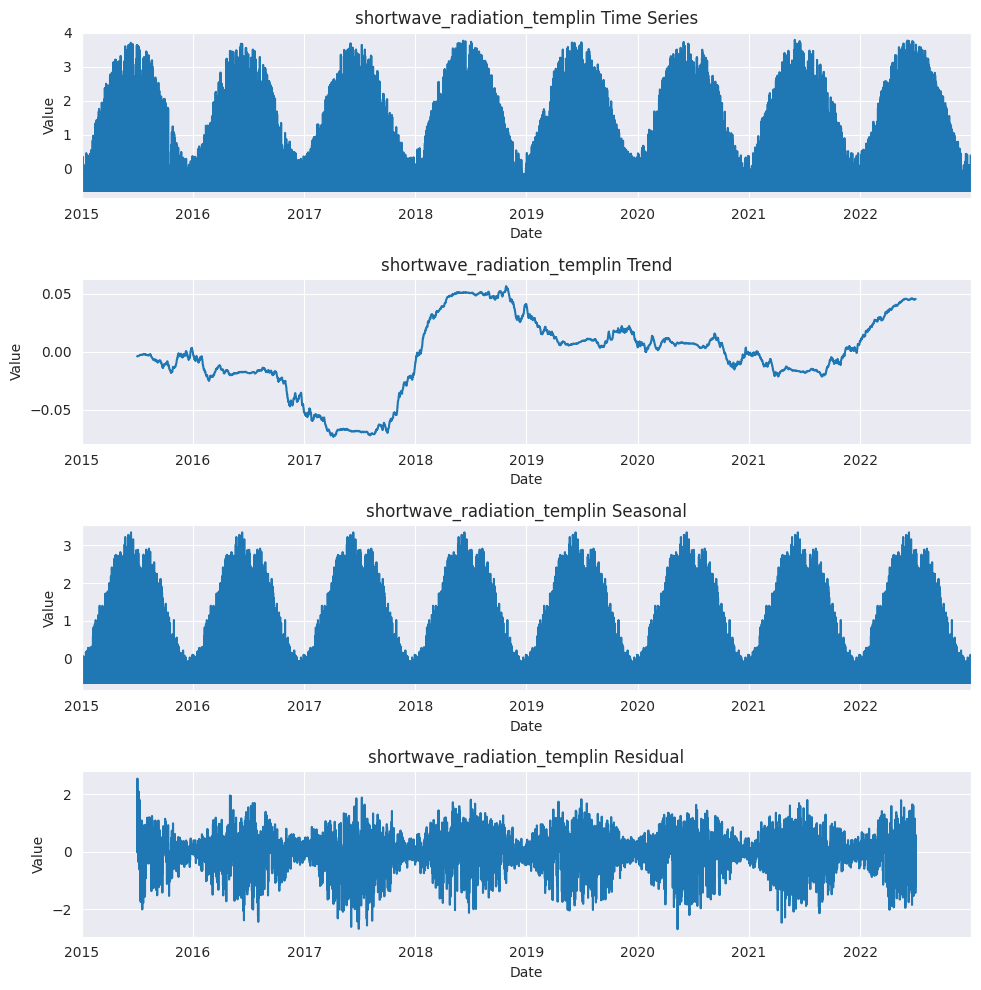

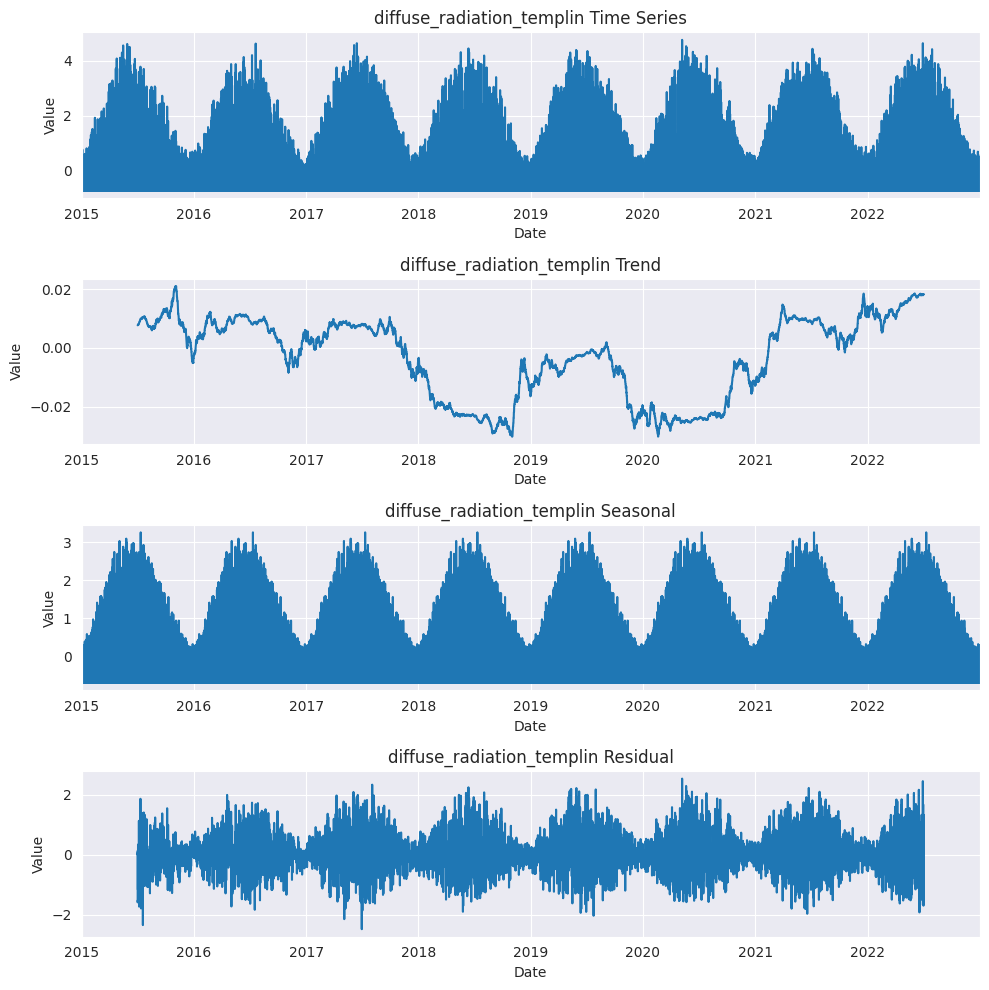

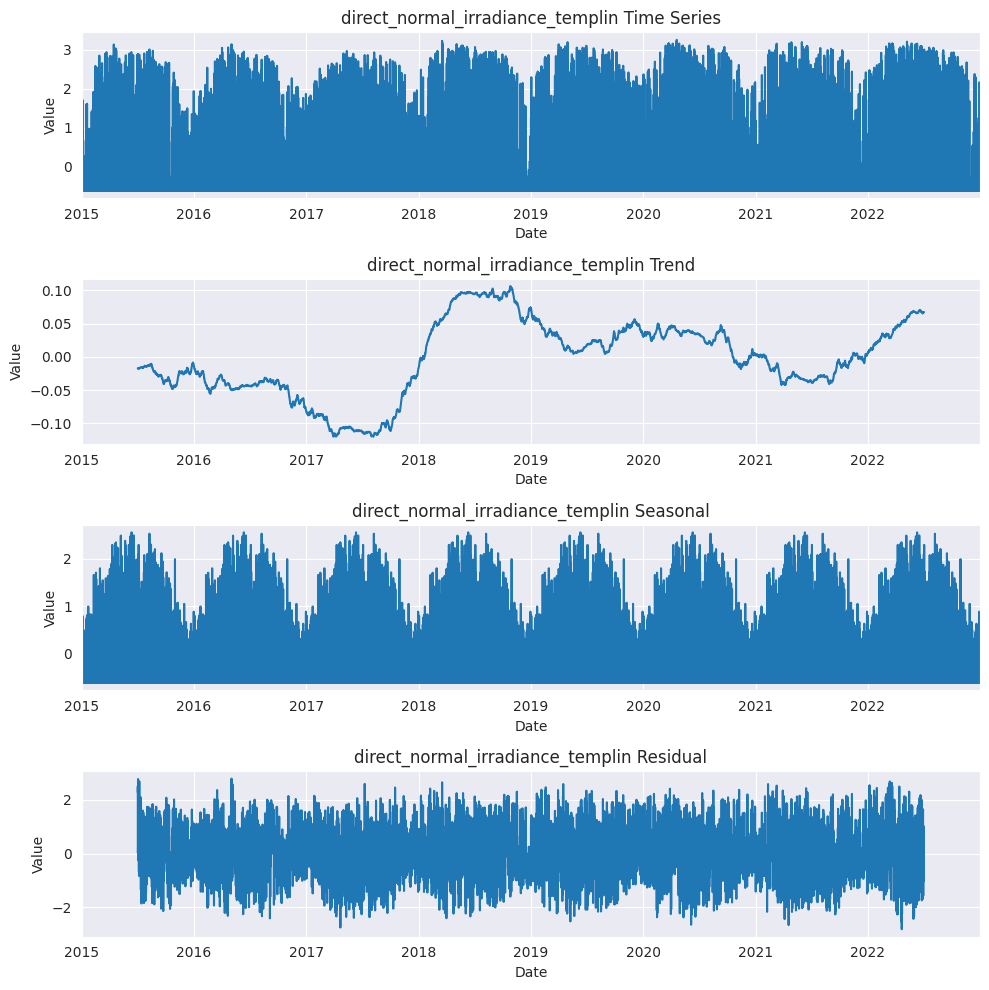

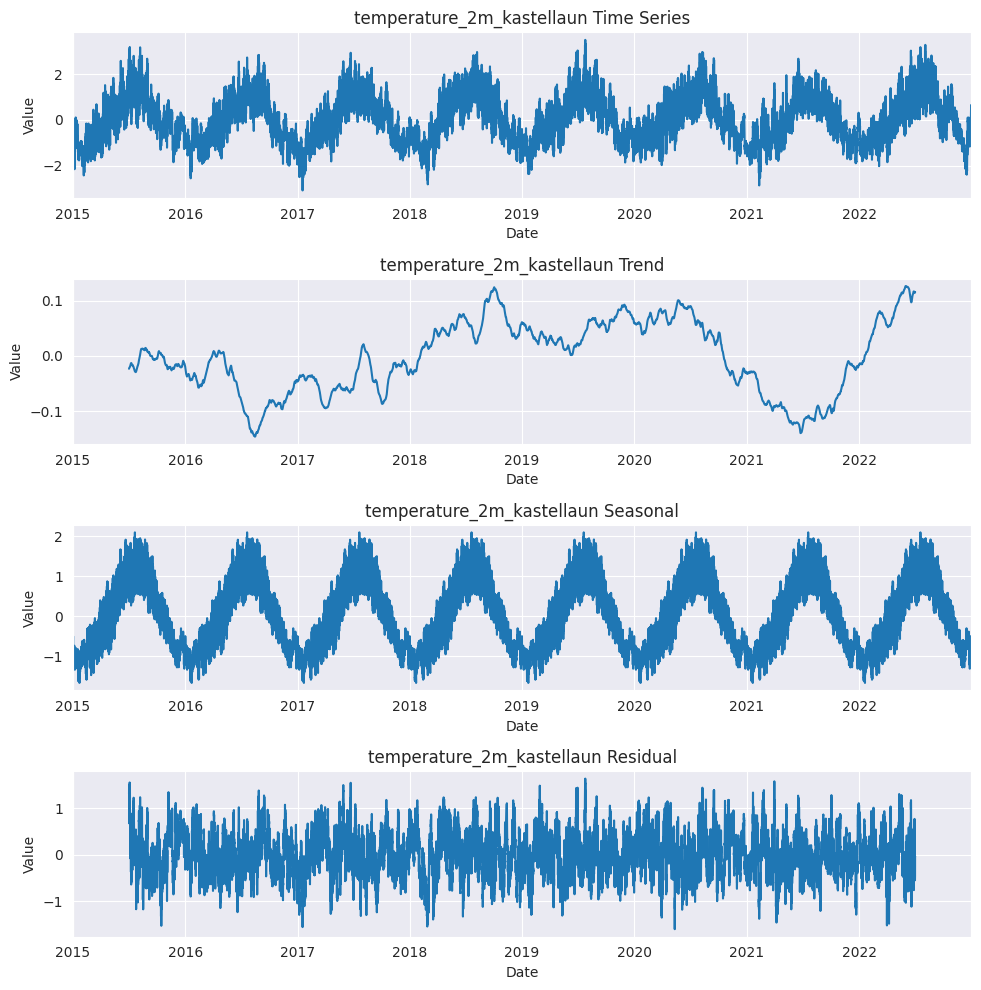

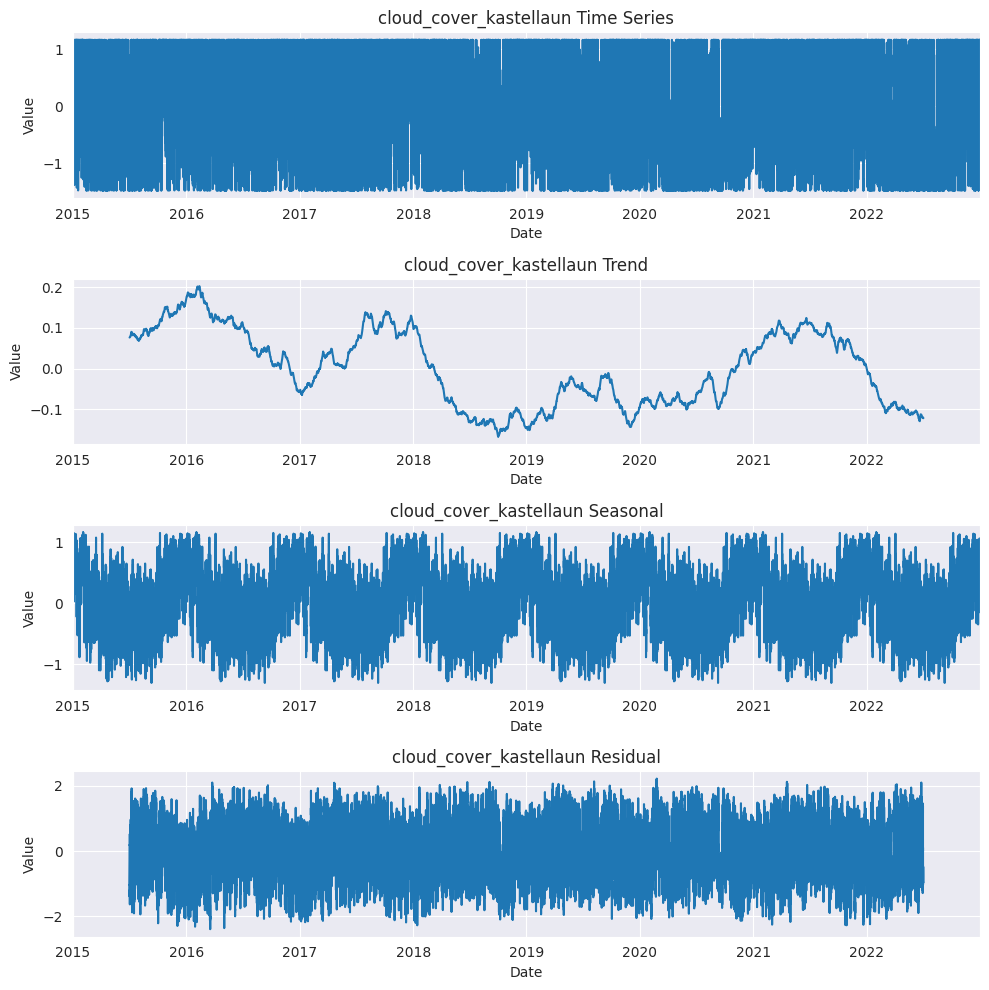

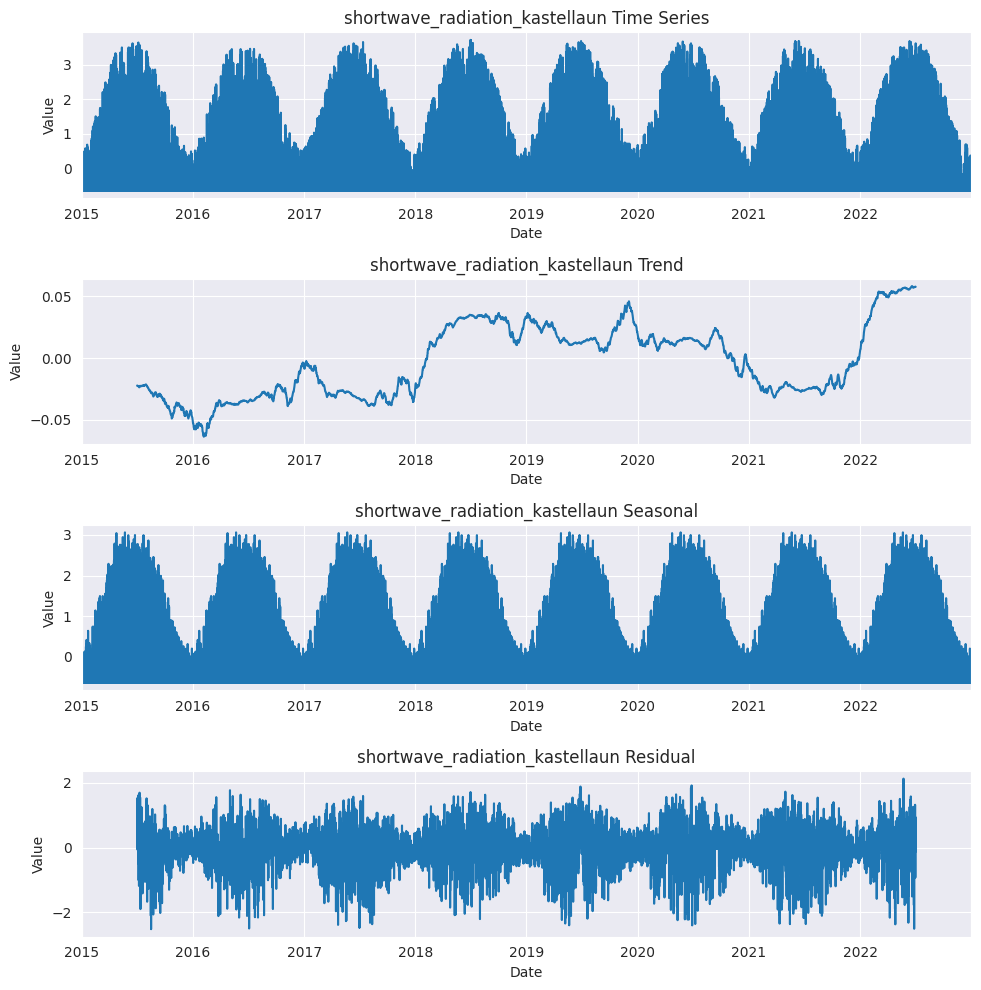

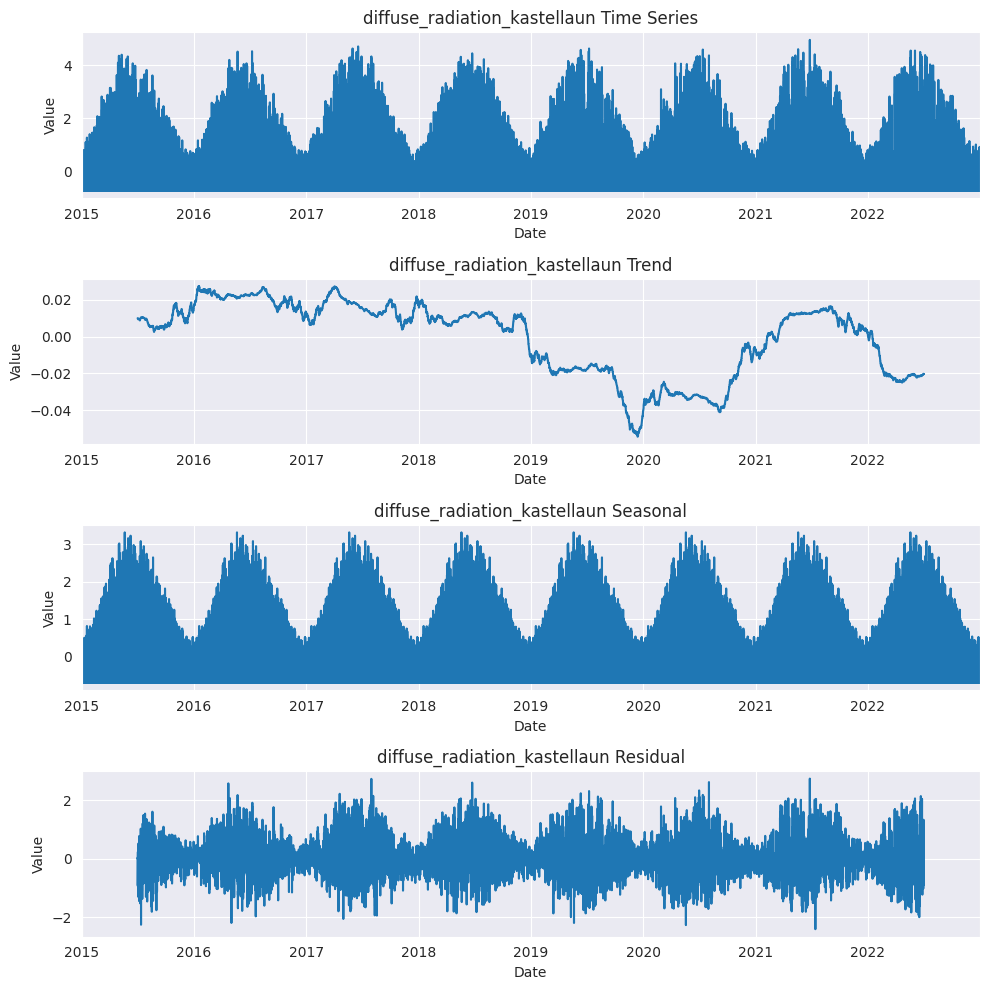

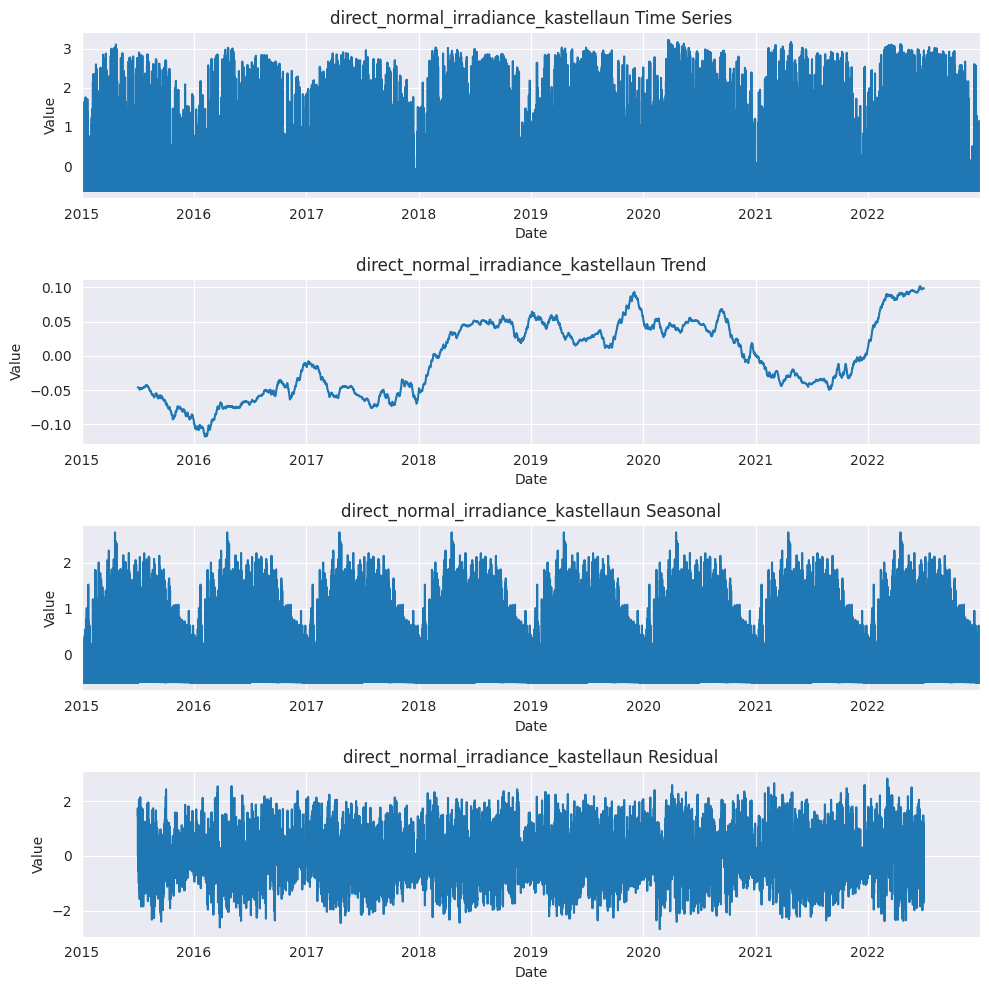

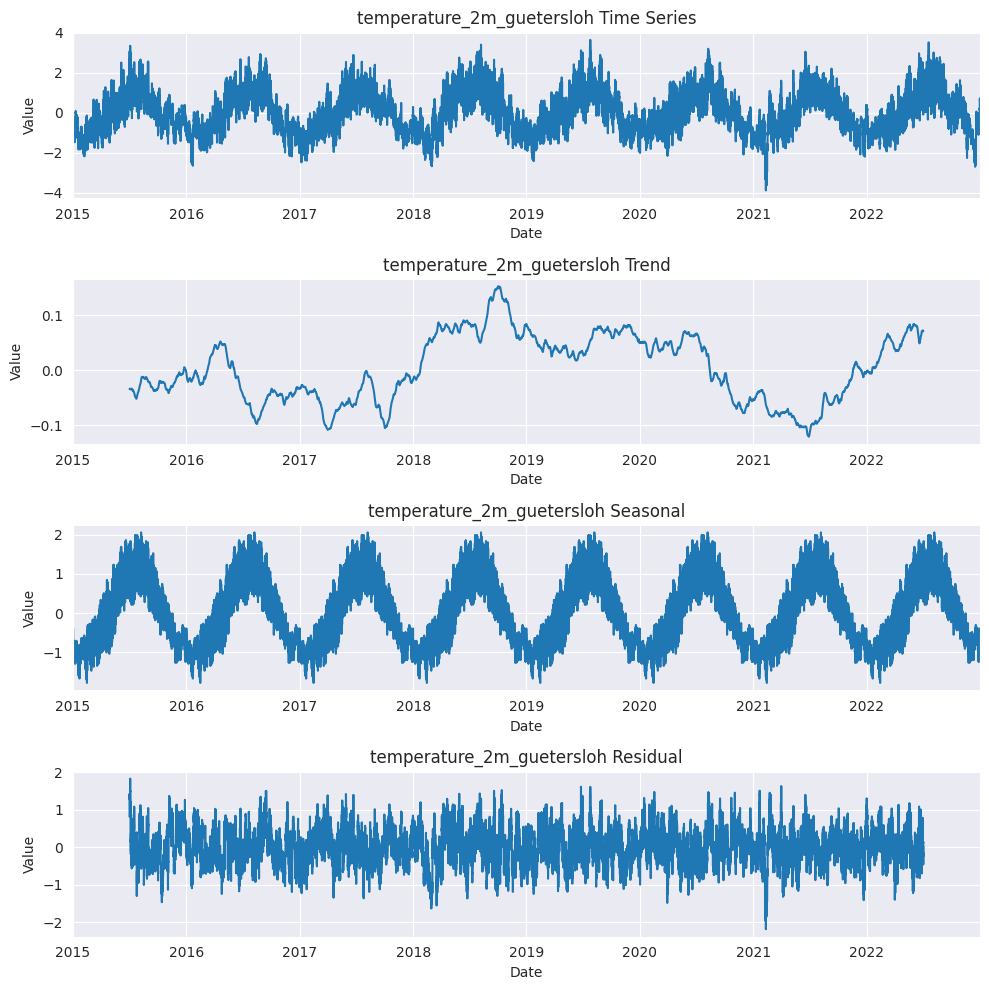

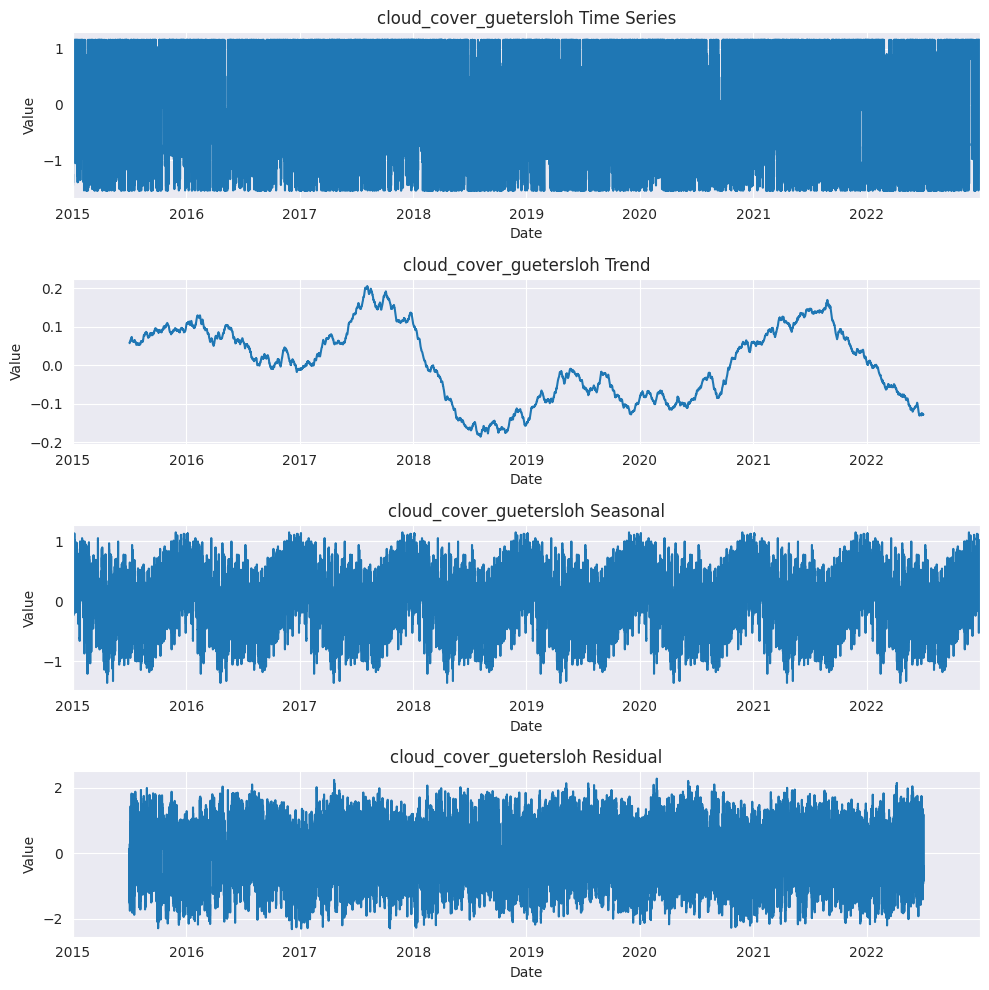

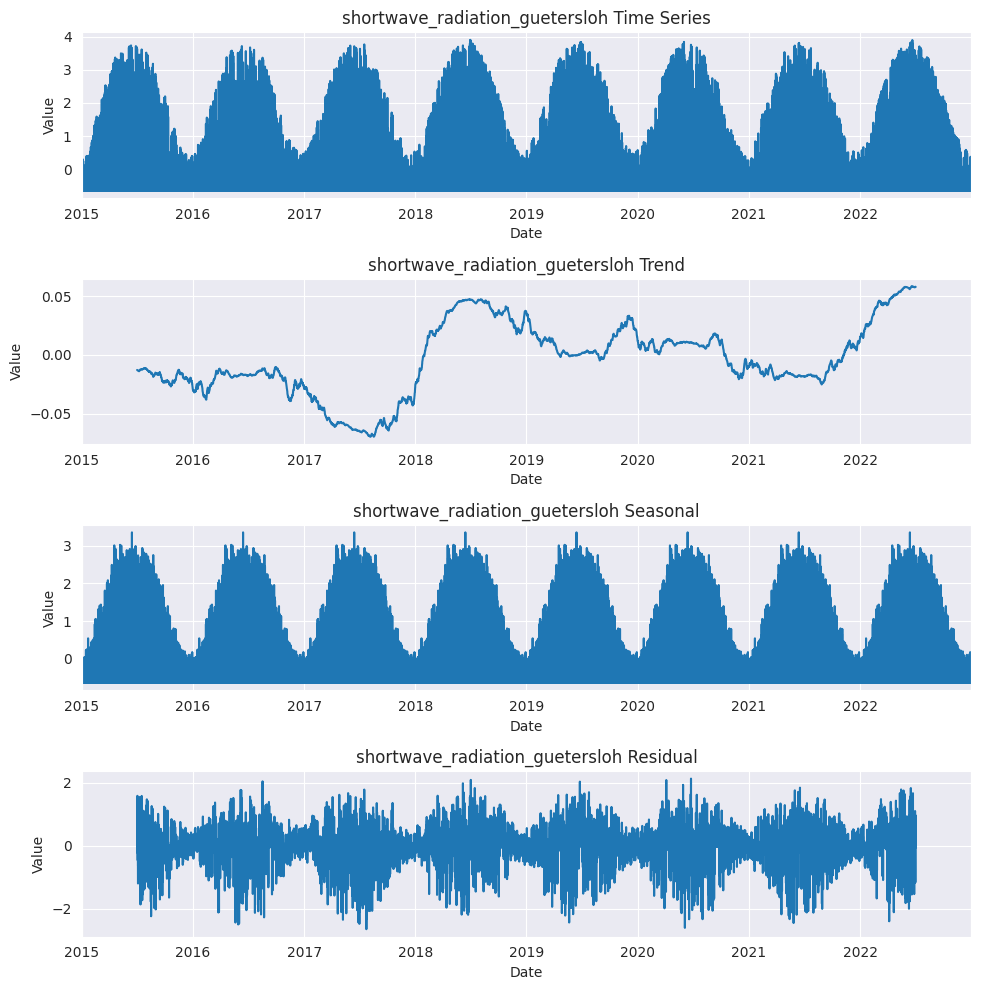

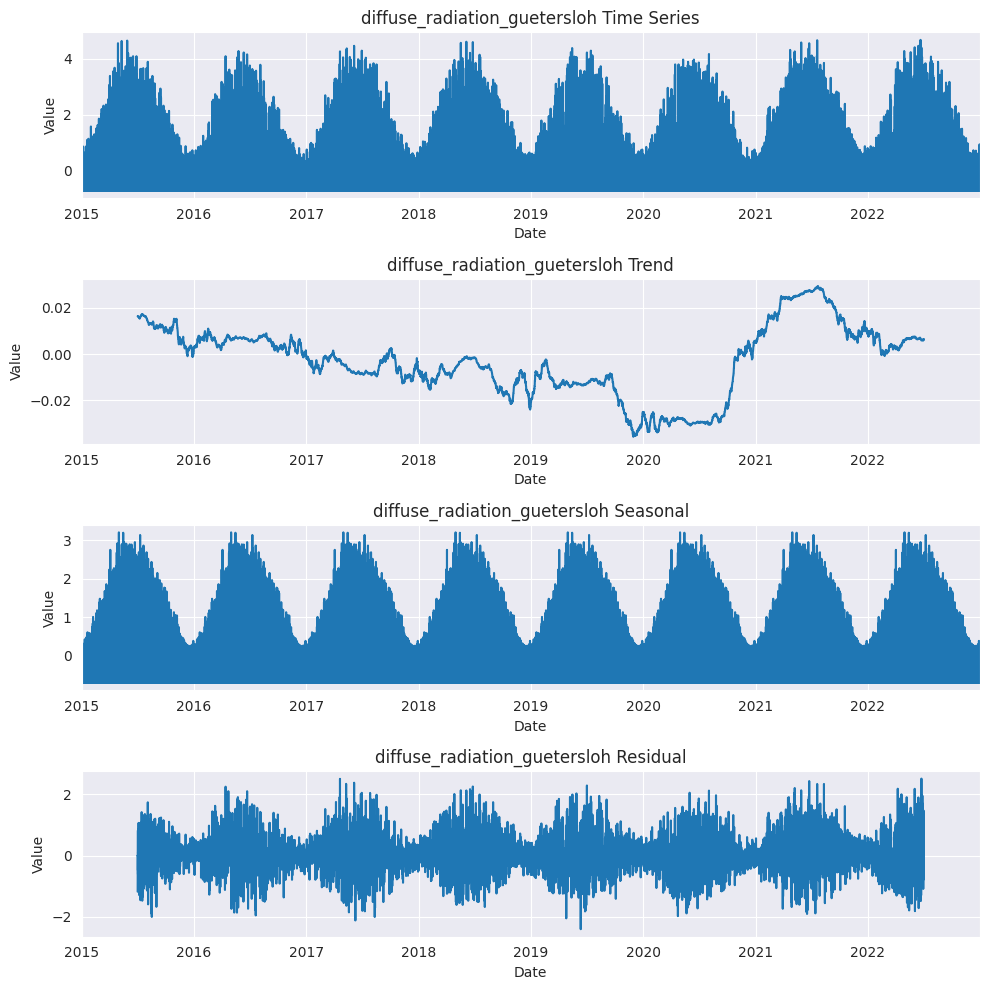

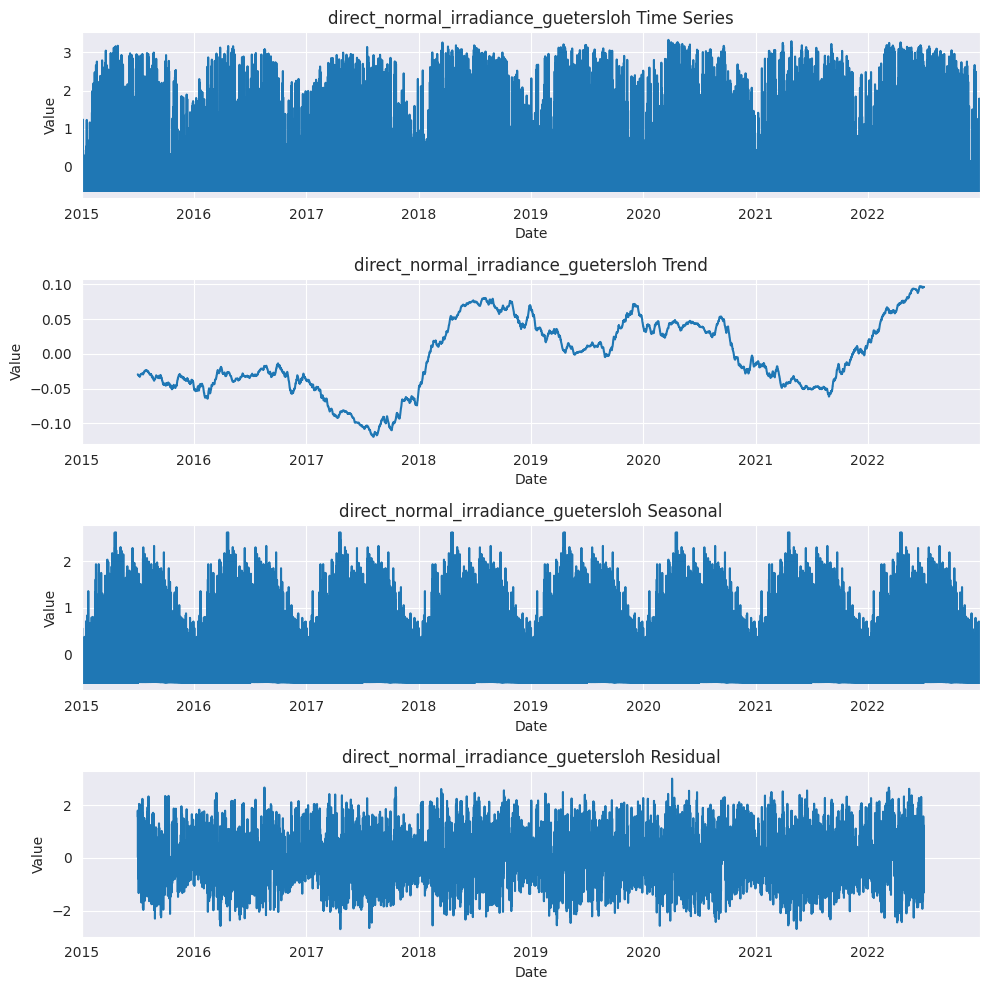

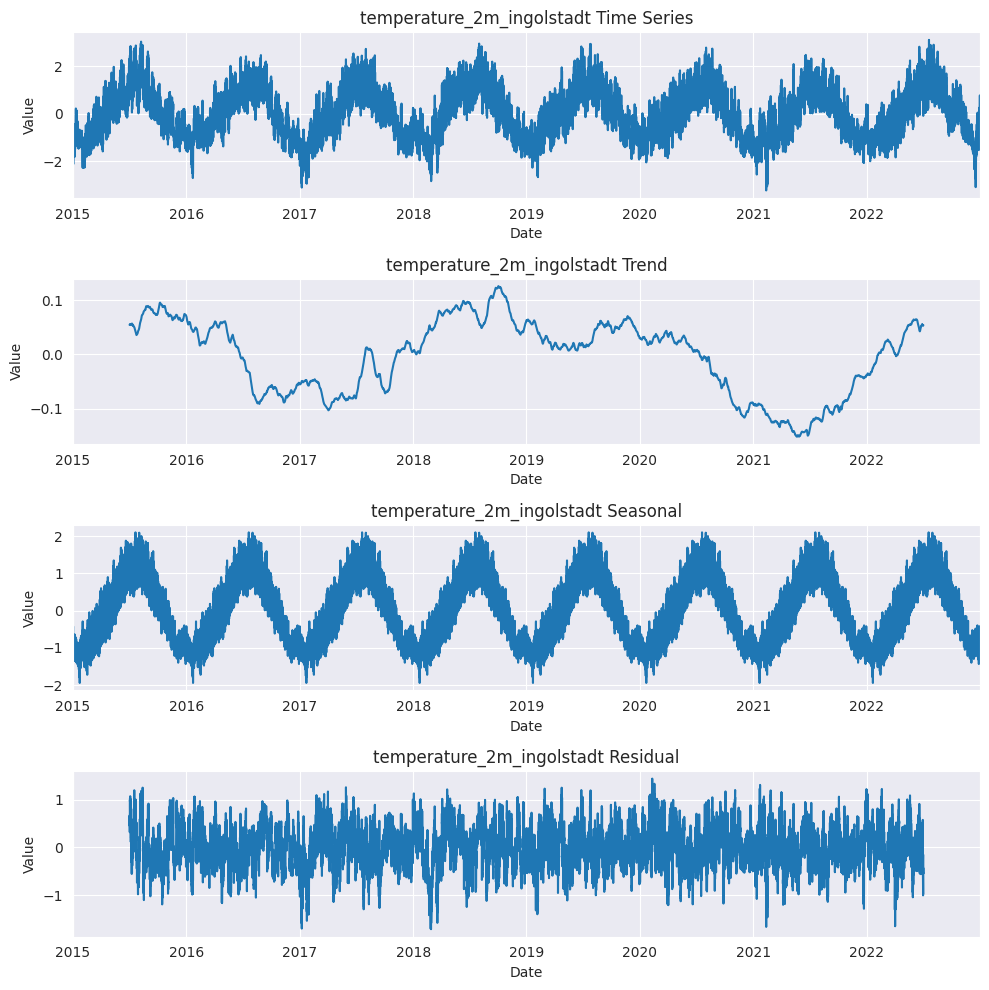

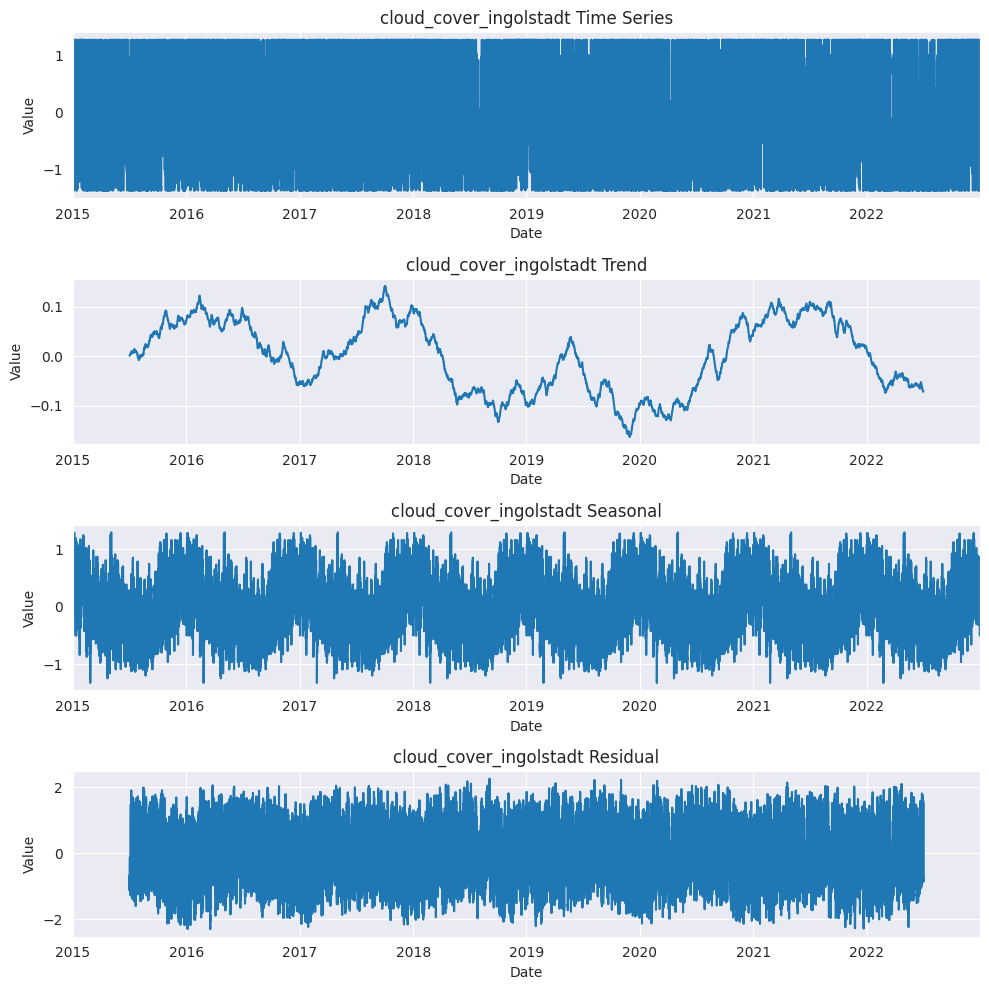

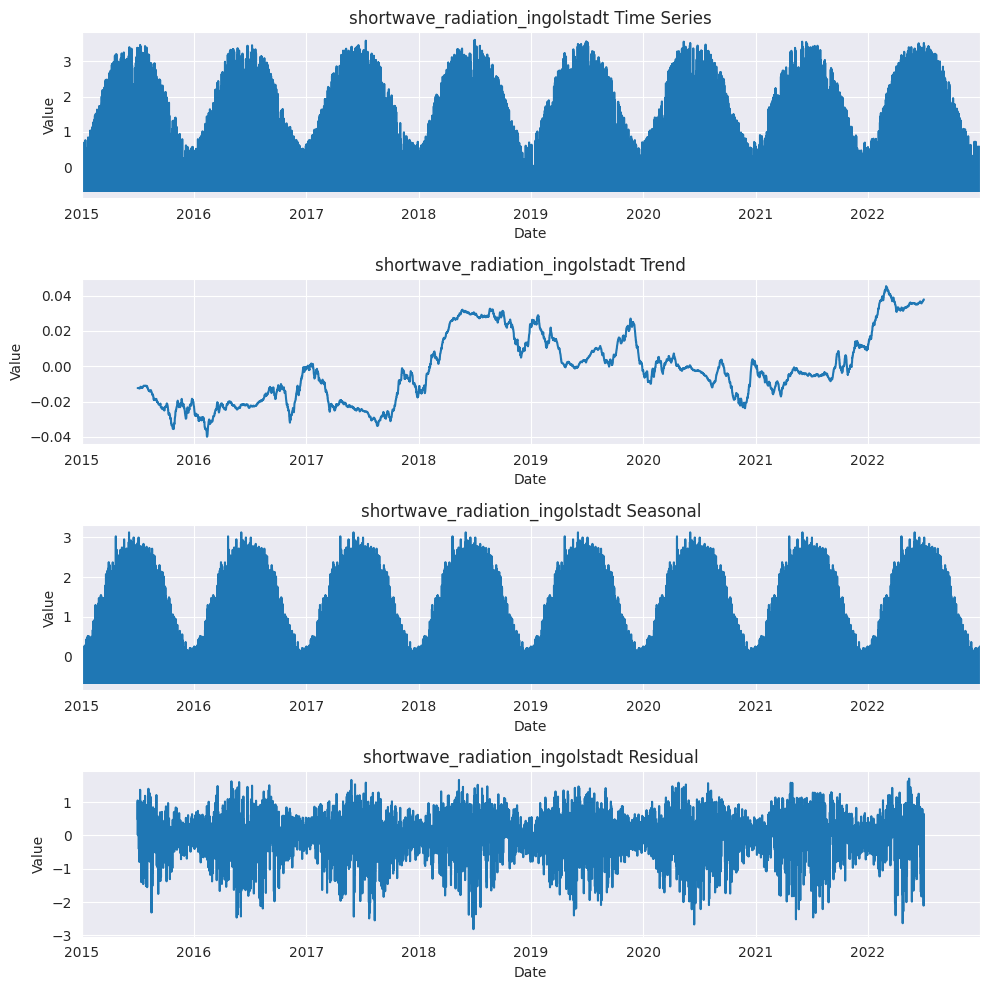

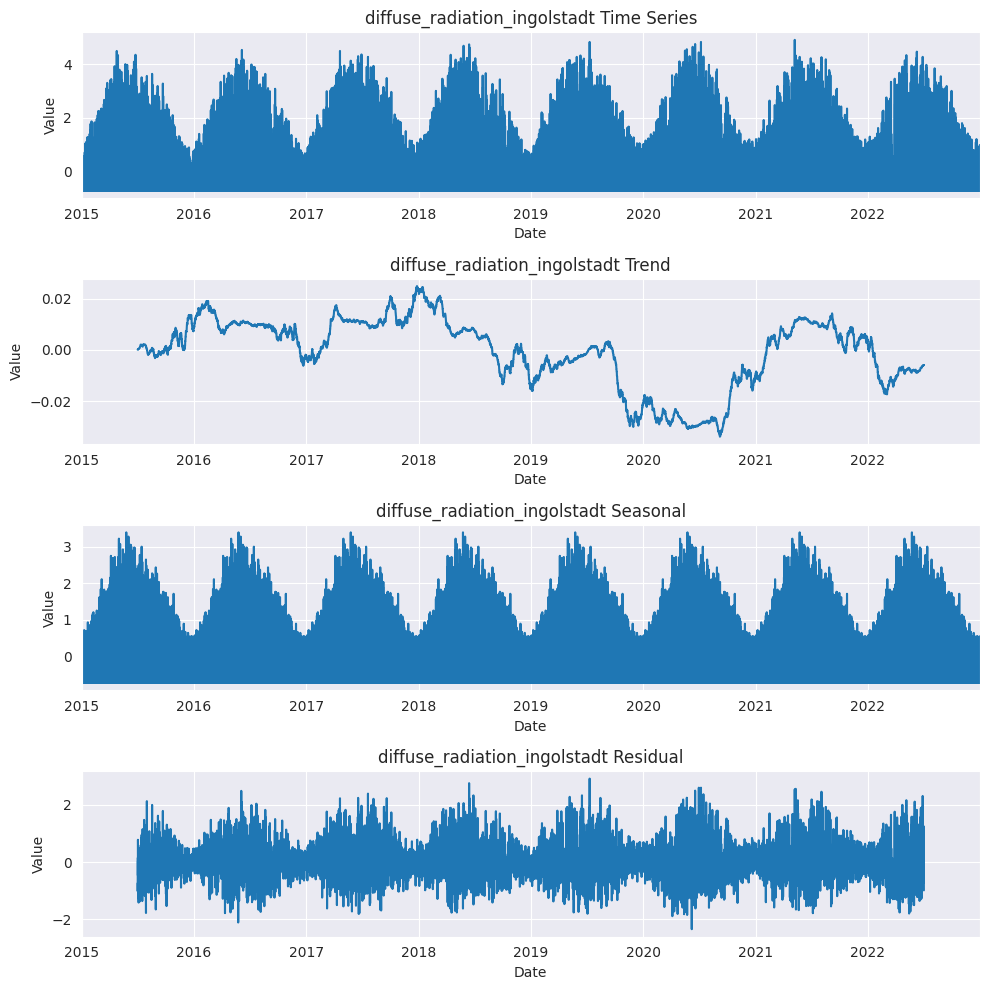

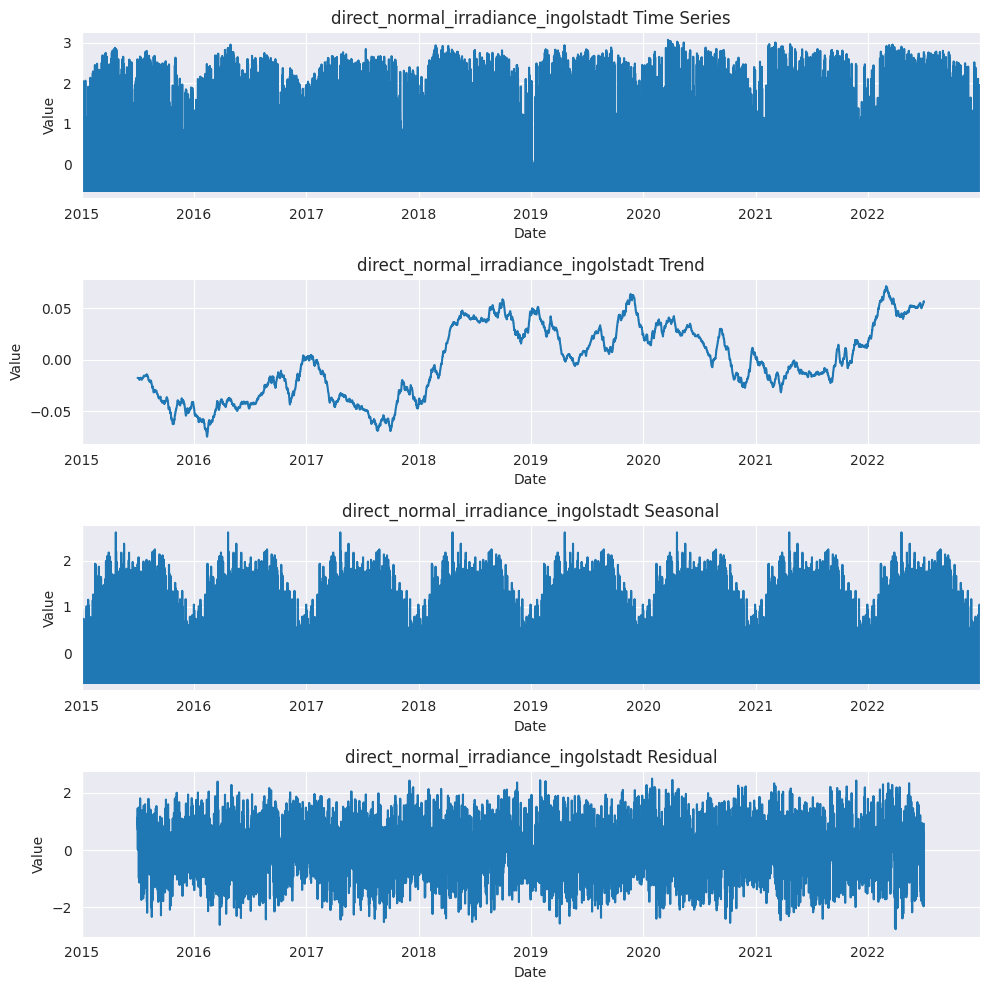

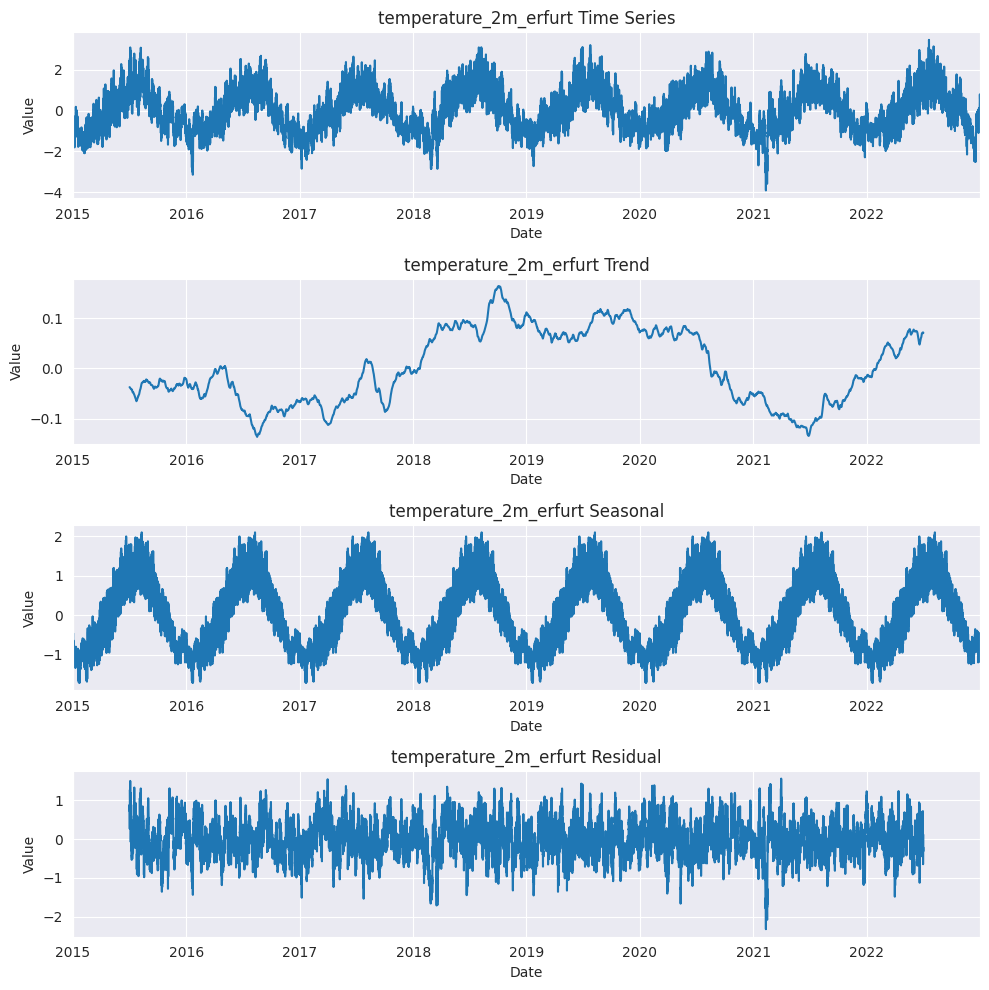

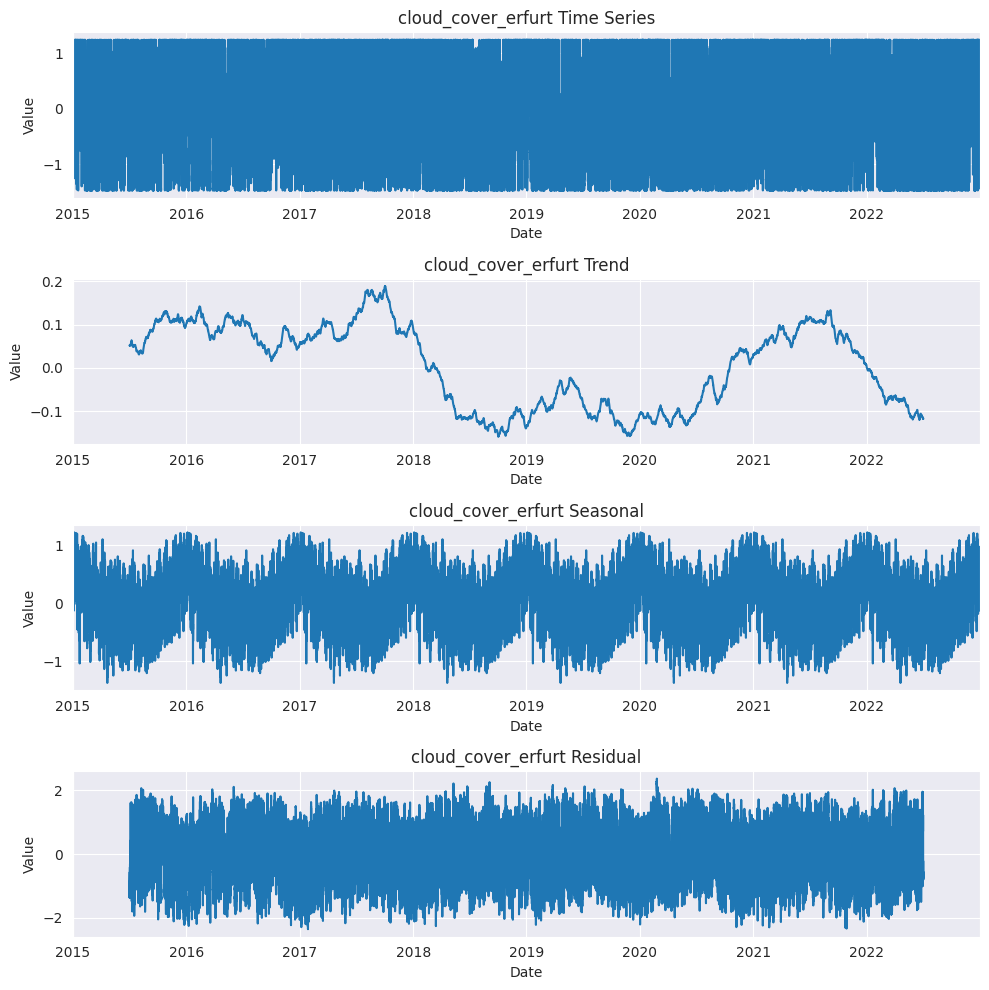

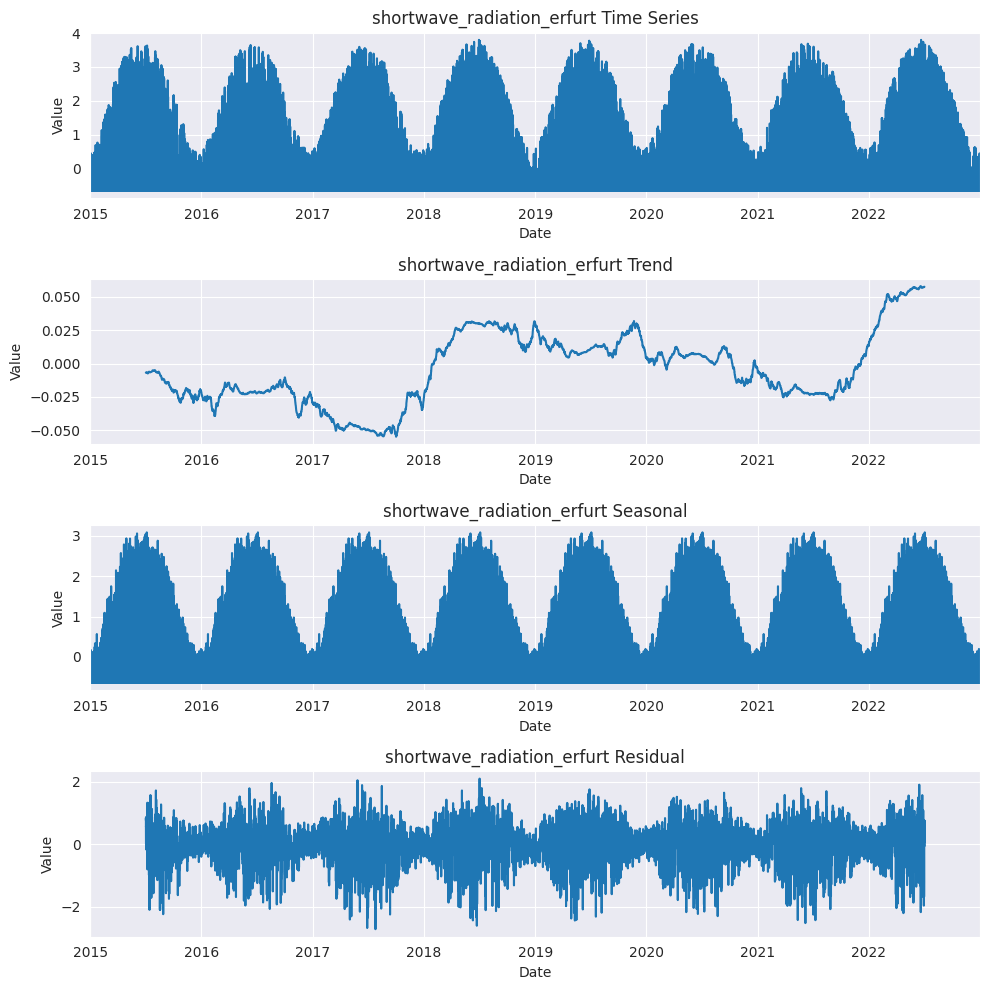

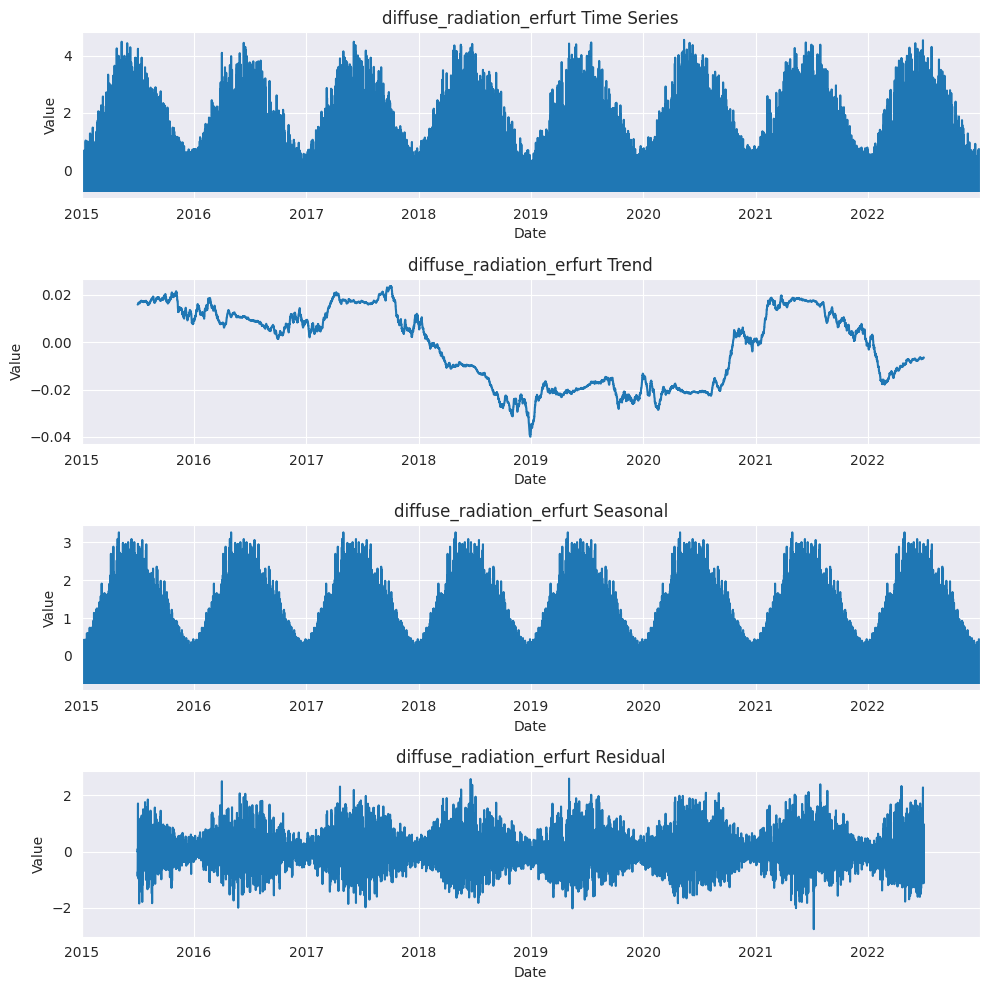

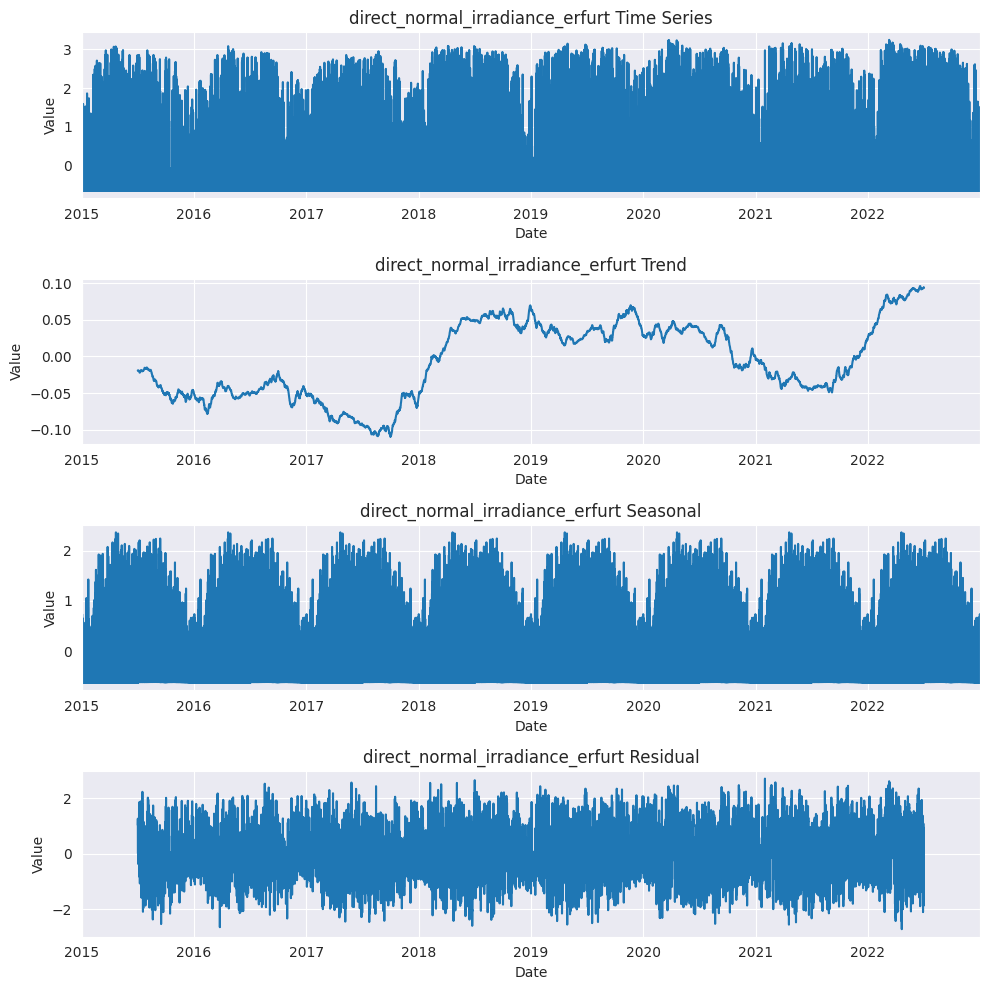

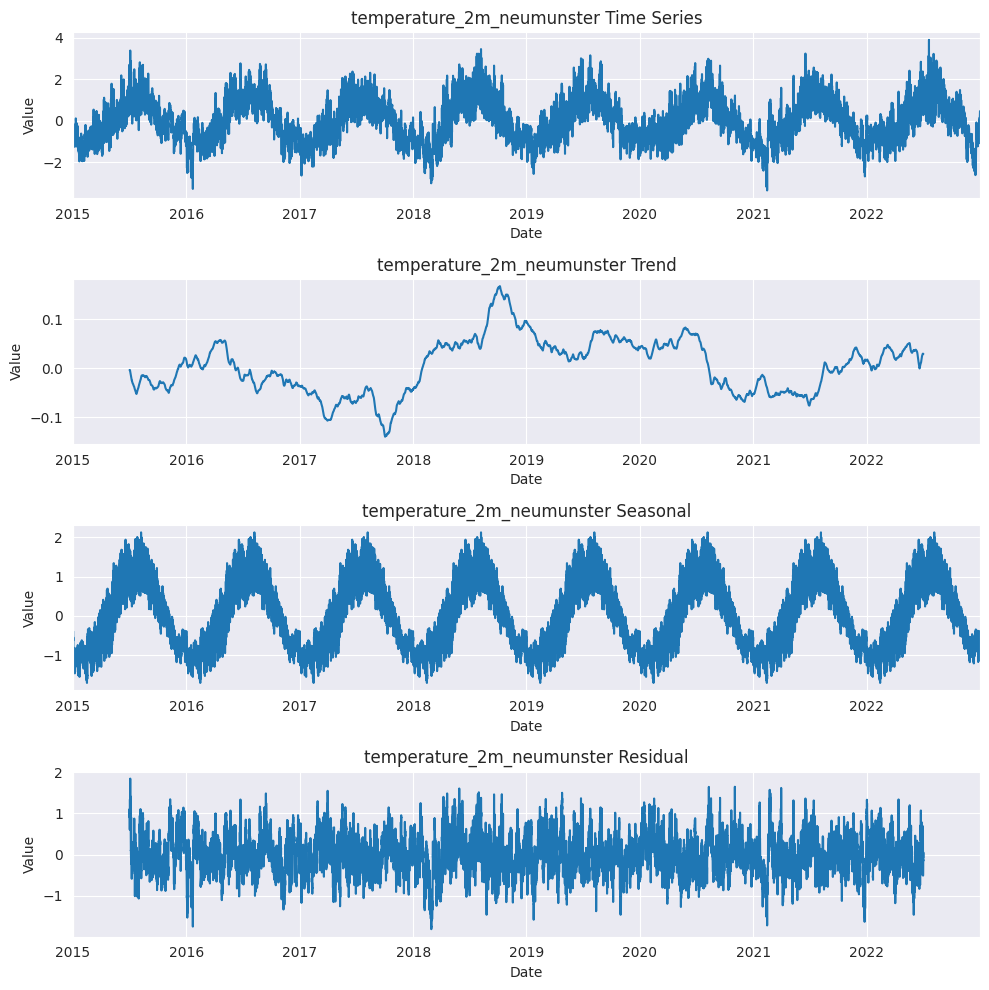

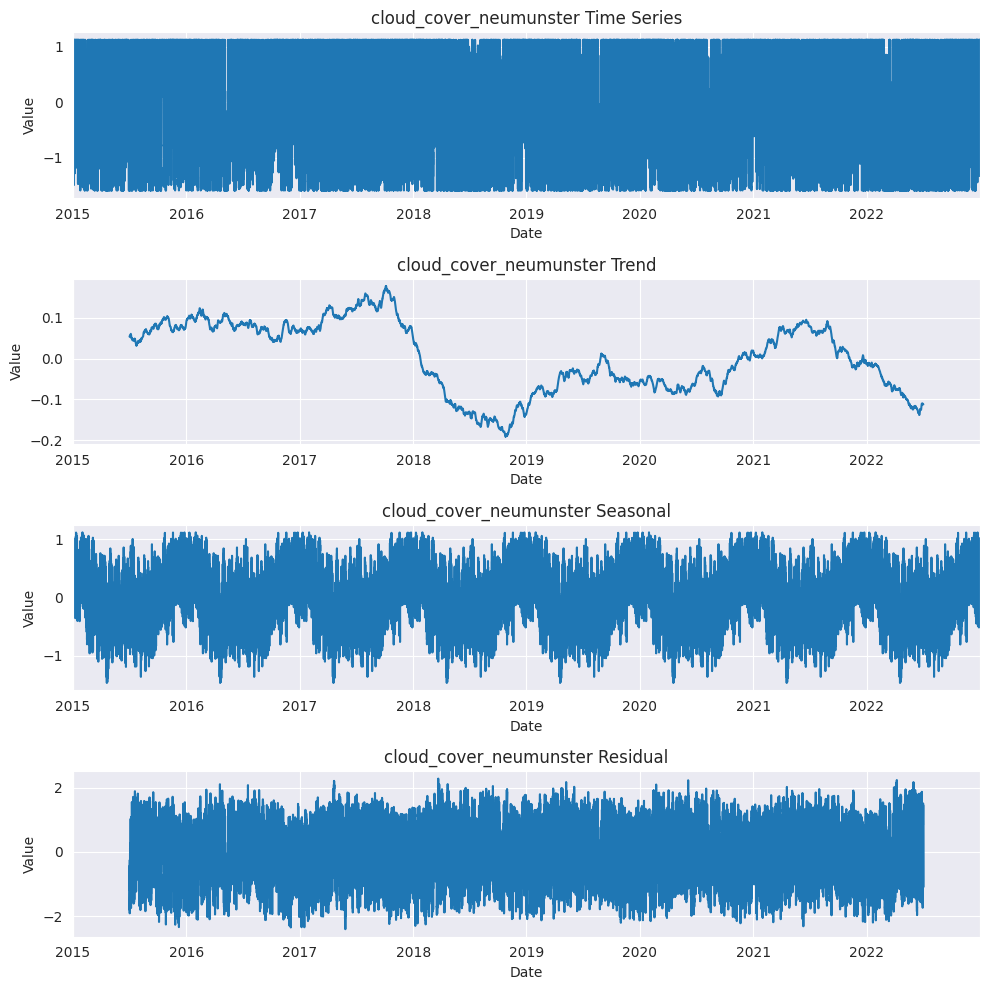

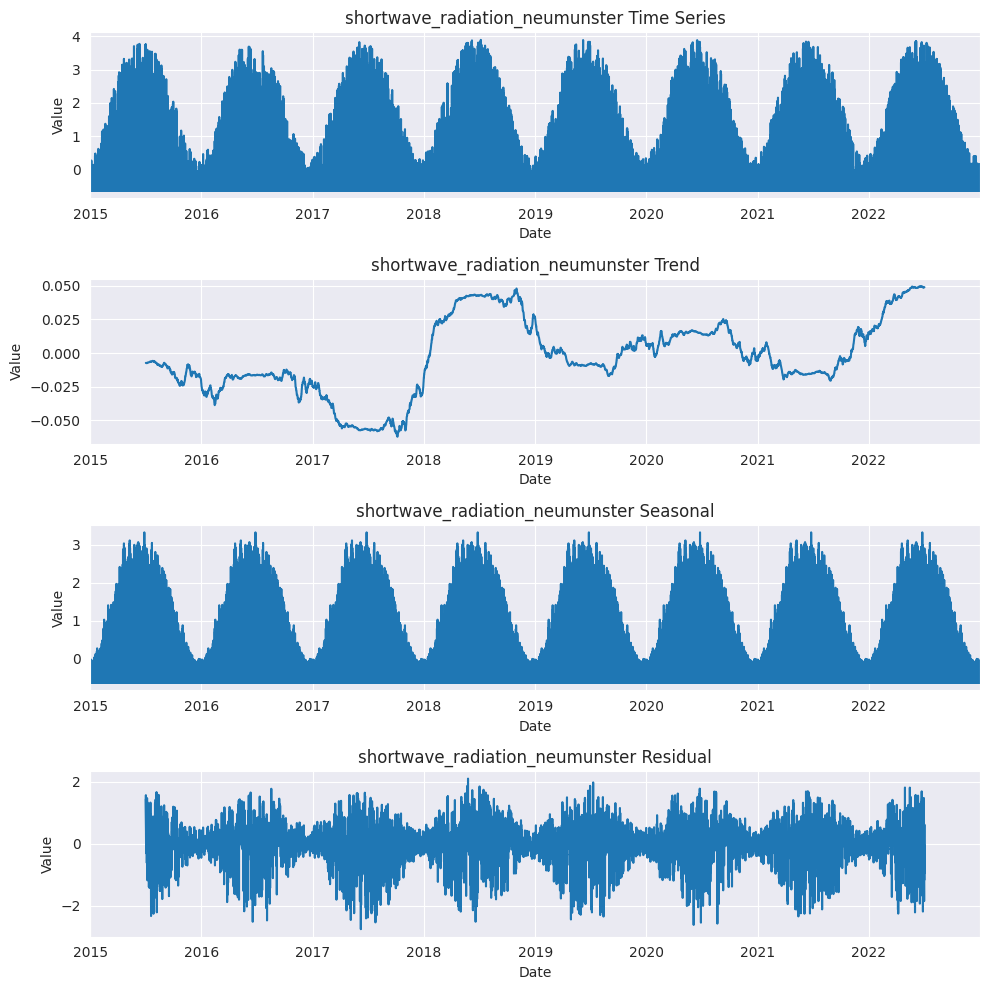

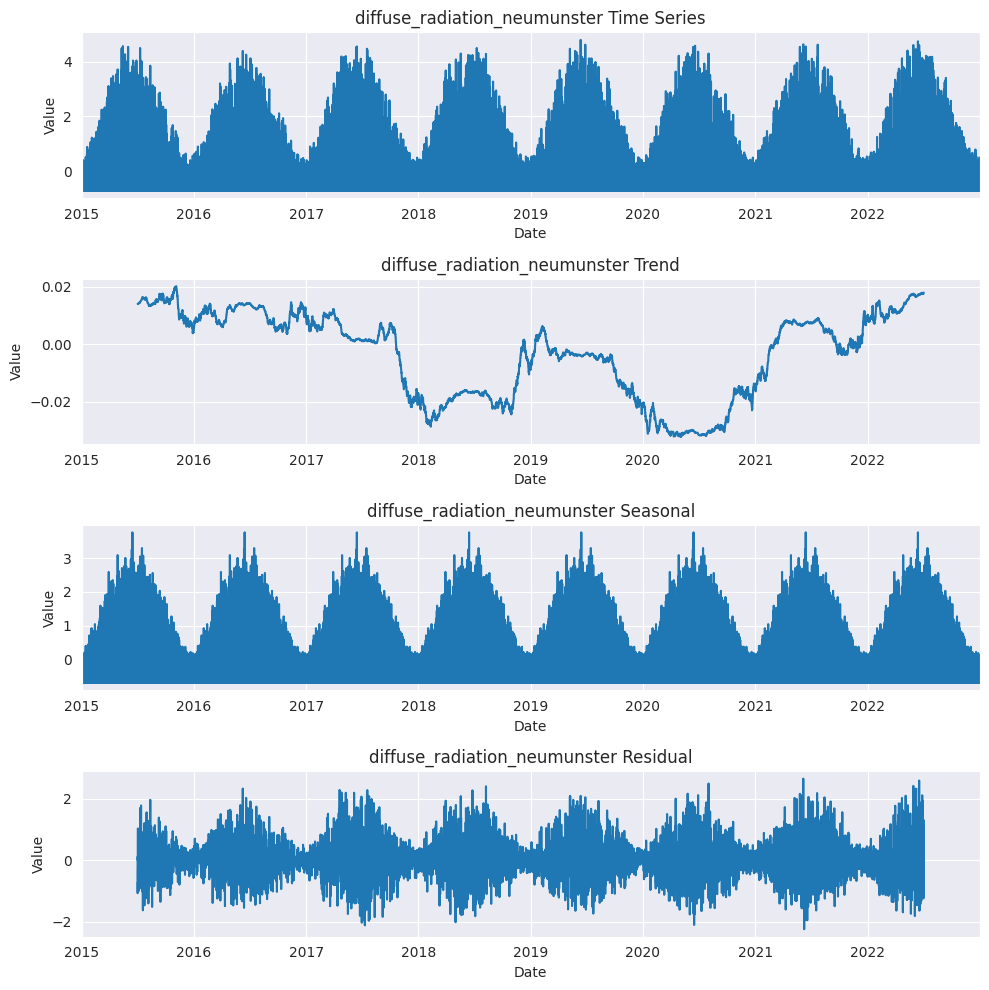

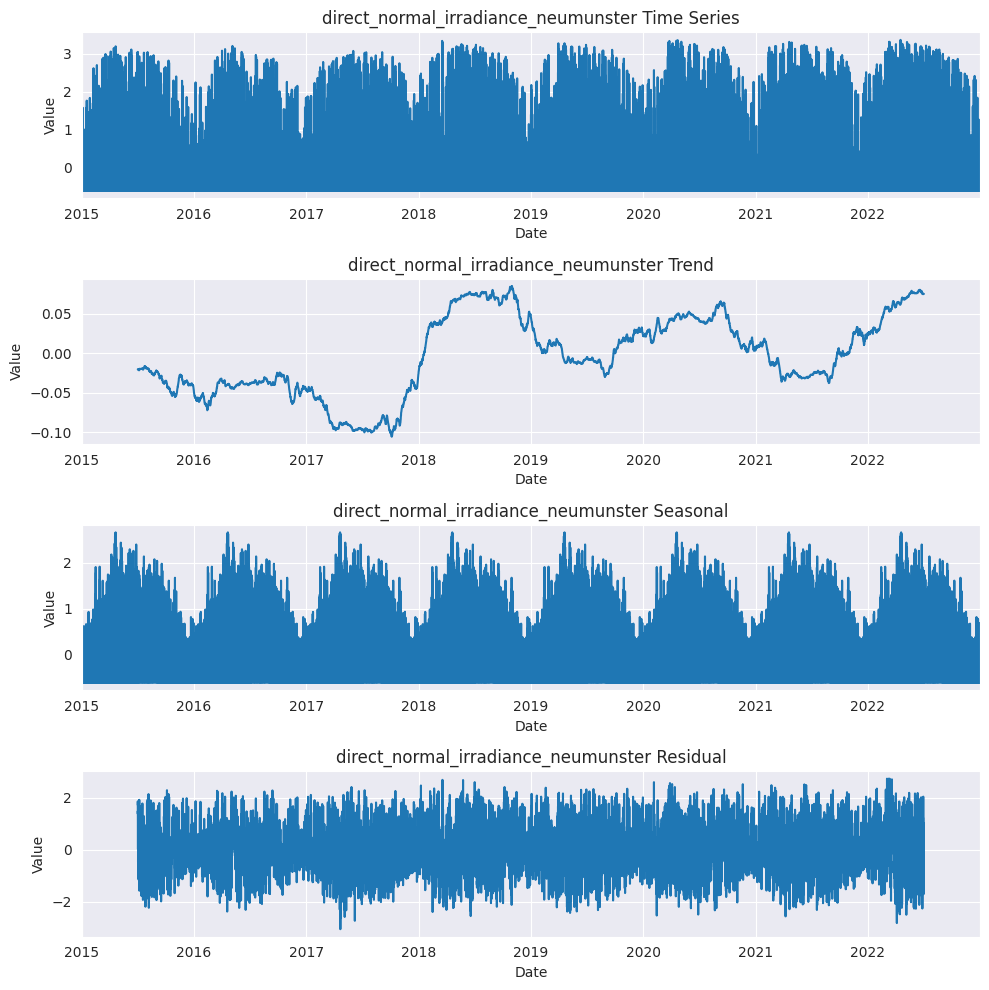

In [34]:
# Plot and decompose each time series as grid of plots
for column in train_ts.columns:
    fig, axes = plt.subplots(4, 1, figsize=(10, 10))
    axes[0].set_title(f"{column} Time Series")
    train_ts[column].plot(ax=axes[0])
    axes[0].set_ylabel("Value")
    axes[0].set_xlabel("Date")
    axes[0].grid(True)
    
    decomposition = seasonal_decompose(train_ts[column], model='additive', period=8760)
    decomposition.trend.plot(ax=axes[1])
    axes[1].set_title(f"{column} Trend")
    axes[1].set_ylabel("Value")
    axes[1].set_xlabel("Date")
    axes[1].grid(True)
    
    decomposition.seasonal.plot(ax=axes[2])
    axes[2].set_title(f"{column} Seasonal")
    axes[2].set_ylabel("Value")
    axes[2].set_xlabel("Date")
    axes[2].grid(True)
    
    decomposition.resid.plot(ax=axes[3])
    axes[3].set_title(f"{column} Residual")
    axes[3].set_ylabel("Value")
    axes[3].set_xlabel("Date")
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()

# Test ACF and PACF

In [ ]:
# Check autocorrelation of each series in the training data and display as grid
for col in train_ts.columns:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(train_ts[col], ax=ax[0], lags=50, title=f'Autocorrelation of {col}')
    plot_pacf(train_ts[col], ax=ax[1], lags=50, title=f'Partial Autocorrelation of {col}')
    plt.show()

# MULTIVARIATE CORRELATION ANALYSIS

In [ ]:
# Scatter Plots (pairwise)
sns.pairplot(train_ts, diag_kind="kde")  
plt.show() 

# Sort features based on target variable correlation (absolute value)
sorted_features = train_ts.corr().iloc[0,:].abs().sort_values(ascending=False).index.tolist()

# Ordered heatmap 
corr_matrix = train_ts[sorted_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="twilight")  
plt.show()

# Correlation Matrix as df
print(corr_matrix.to_string())  # Print the correlation matrix as text

In [ ]:
# Granger Causality Tests for the series in train_ts
for col in train_ts.columns:
    for col2 in train_ts.columns:
        if col != col2:
            print(f'Granger Causality Test for {col} and {col2}')
            data = pd.concat([train_ts[col], train_ts[col2]], axis=1)
            max_lag = 12
            results = grangercausalitytests(data, max_lag, verbose=True)
            print("\n")  # Add a space between outputs